# NMD on raw counts

- NMD-3b & NMD-T
- Hyperparameter search (latent dimension & momentum parameter beta)
- on raw counts

## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
%%capture

!pip install scanpy

In [2]:
%%capture
!pip install KDEpy

In [3]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import warnings
warnings.filterwarnings("ignore")

In [4]:
import importlib

In [5]:
def plot_embedding_grid(embeddings, hue=None, title_prefix="", sample_fraction=1.0):
    """
    Plots a grid of scatterplots for all pairwise combinations of embeddings.

    :param embeddings: NumPy array of shape (n_samples, n_features)
    :param hue: Series or list of hue values for coloring points based on clustering
    :param title_prefix: Optional prefix for the plot titles
    """
    # Convert embeddings to a DataFrame
    df_embeddings = pd.DataFrame(embeddings)
    
    df_embeddings = df_embeddings.sample(frac=sample_fraction, axis=0)
    

    if hue is None:
        g = sns.pairplot(df_embeddings, plot_kws={"s": 20, "alpha": 0.3})
    else:
        df_embeddings['Cluster'] = list(hue)
        g = sns.pairplot(df_embeddings, hue='Cluster', plot_kws={"s": 20, "alpha": 0.3})
    
    # Set titles for each subplot
    for i in range(df_embeddings.shape[1] - 1):
        for j in range(i + 1, df_embeddings.shape[1] - 1):
            # g.axes[j, i].set_title(f"{title_prefix}: Dim {i+1} vs Dim {j+1}")
            g.axes[j, i].set_xlabel(f"Embedding Dim {i+1}")
            g.axes[j, i].set_ylabel(f"Embedding Dim {j+1}")

    plt.show()

## Preprocessing
### Read data

In [6]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [7]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [8]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [9]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1255
True       71
Name: outlier, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

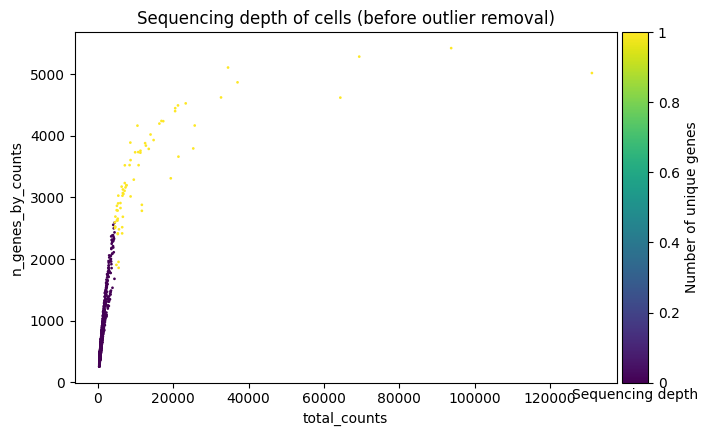

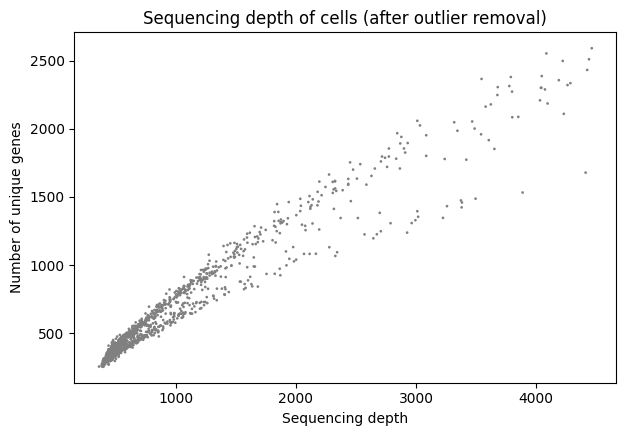

In [10]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

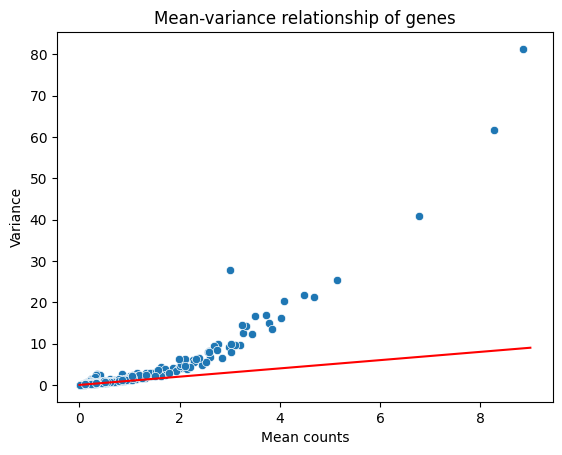

In [12]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [13]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

<Axes: xlabel='nb_mean', ylabel='Count'>

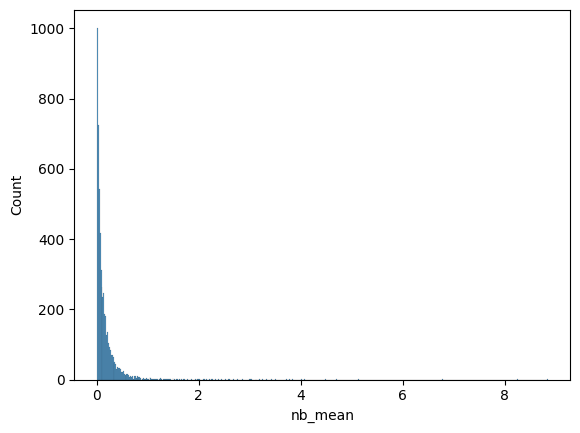

In [14]:
sns.histplot(data_gene.var["nb_mean"])

In [15]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

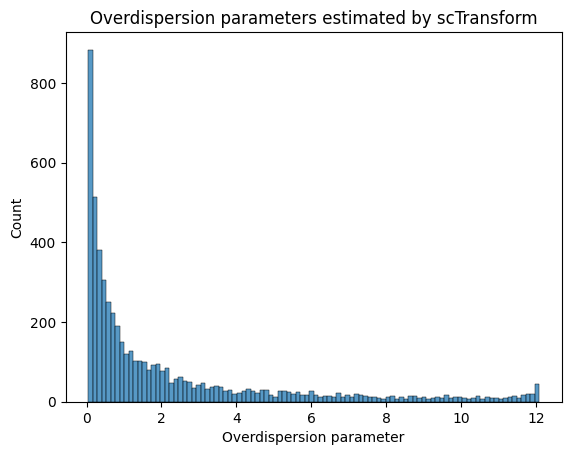

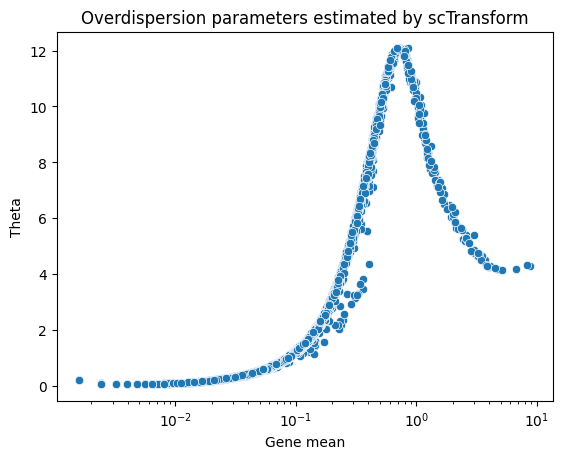

In [16]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

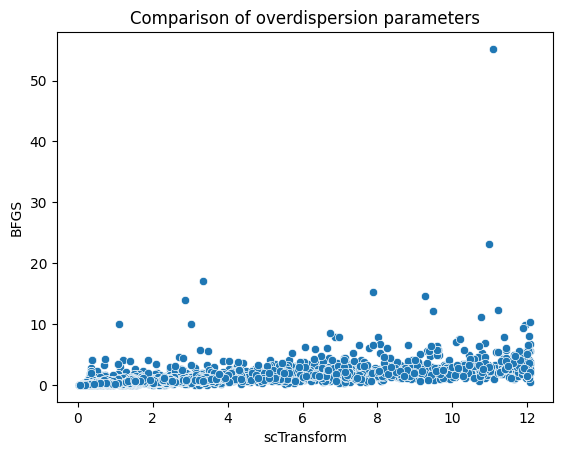

Correlation: [[1.         0.62756785]
 [0.62756785 1.        ]]


In [17]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [18]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [19]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

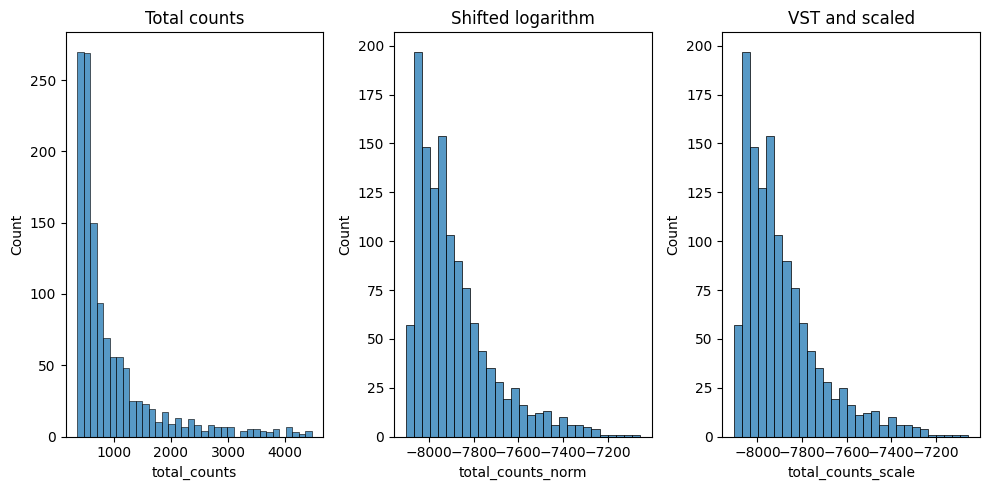

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [21]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5421
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [22]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

## Parameter search: NMD

In [23]:
importlib.reload(cs)

<module 'tools.countsplit' from '/dss/dsshome1/07/di35buw/NMD/BacSC_Moba/tools/countsplit.py'>

In [24]:
data_layer = "counts"

In [27]:
#ks_2_check = [15, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
ks_2_check = [512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
# betas_2_check = [0.4, 0.6, 0.7, 0.8, 0.9]
betas_2_check = [0.6, 0.7, 0.8]

In [28]:
select_cs_3b_results = cs.select_3b_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer, tol_over_10iters=1e-3)

################## LATENT DIM 512
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 256
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 128
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 64
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 32
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 16
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 4
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 2
################## BETA 0.6
###

In [29]:
select_cs_3b_results.sort_values(by="loss").head(20)

,k,beta,loss
25,2,0.7,888.835961
24,2,0.6,889.038904
27,1,0.6,891.669300
28,1,0.7,892.326403
26,2,0.8,893.414538
29,1,0.8,902.877502
22,4,0.7,912.351624
21,4,0.6,913.853553
23,4,0.8,915.910275
20,8,0.8,935.160536


<Axes: xlabel='k', ylabel='loss'>

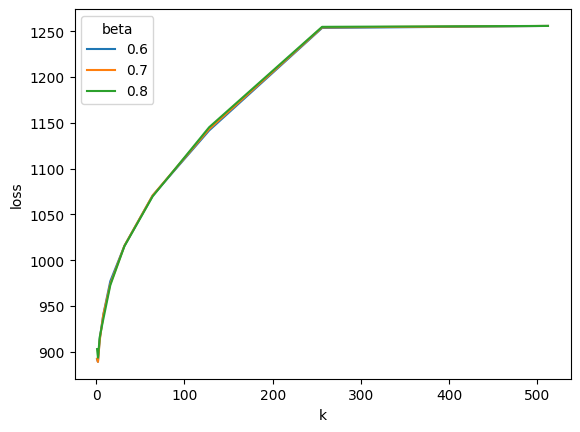

In [30]:
sns.lineplot(data=select_cs_3b_results, x="k", y="loss", hue="beta", palette="tab10")

## NMD 3-B

In [31]:
from tools import NMD as nmd

In [45]:
k_opt_3b = 350
beta_opt_3b = 0.7
data_layer = "counts"

In [46]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b)
Theta0 = W0 @ H0

In [47]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt_3b, W0=W0, H0=H0, beta1=beta_opt_3b, tol_over_10iters=1e-3)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 33.470146] - 0.749188 secs
[1 : 29.128389] - 0.729239 secs
[2 : 25.624347] - 0.724829 secs
[3 : 23.295360] - 0.733614 secs
[4 : 21.676226] - 0.722016 secs
[5 : 20.508590] - 0.723639 secs
[6 : 19.626278] - 0.730702 secs
[7 : 18.929741] - 0.722517 secs
[8 : 18.355931] - 0.726384 secs
[9 : 17.866226] - 0.729109 secs
[10 : 17.436447] - 0.724987 secs
[11 : 17.051007] - 0.724187 secs
[12 : 16.700137] - 0.733108 secs
[13 : 16.377422] - 0.722234 secs
[14 : 16.077990] - 0.728341 secs
[15 : 15.798414] - 0.729433 secs
[16 : 15.535978] - 0.723162 secs
[17 : 15.288634] - 0.722702 secs
[18 : 15.054707] - 0.729075 secs
[19 : 14.832811] - 0.723954 secs
[20 : 14.621780] - 0.729365 secs
[21 : 14.420509] - 0.730681 secs
[22 : 14.228147] - 0.727504 secs
[23 : 14.043959] - 0.728705 secs
[24 : 13.867205] - 0.728940 secs
[25 : 13.697371] - 0.724606 secs
[26 : 13.533988] - 0.724531 secs
[27 : 13.376640] - 0.725576 

[247 : 4.994486] - 0.723287 secs
[248 : 4.982081] - 0.721352 secs
[249 : 4.969739] - 0.726308 secs
[250 : 4.957458] - 0.722583 secs
[251 : 4.945239] - 0.724516 secs
[252 : 4.933082] - 0.732789 secs
[253 : 4.920986] - 0.721258 secs
[254 : 4.908948] - 0.721427 secs
[255 : 4.896969] - 0.726110 secs
[256 : 4.885050] - 0.723319 secs
[257 : 4.873189] - 0.722359 secs
[258 : 4.861386] - 0.729372 secs
[259 : 4.849641] - 0.723352 secs
[260 : 4.837953] - 0.722577 secs
[261 : 4.826321] - 0.724889 secs
[262 : 4.814747] - 0.723163 secs
[263 : 4.803230] - 0.720977 secs
[264 : 4.791769] - 0.728001 secs
[265 : 4.780362] - 0.726271 secs
[266 : 4.769011] - 0.729437 secs
[267 : 4.757715] - 0.725177 secs
[268 : 4.746471] - 0.724585 secs
[269 : 4.735281] - 0.721943 secs
[270 : 4.724143] - 0.723207 secs
[271 : 4.713057] - 0.724129 secs
[272 : 4.702024] - 0.737799 secs
[273 : 4.691043] - 0.738395 secs
[274 : 4.680113] - 0.720530 secs
[275 : 4.669233] - 0.720240 secs
[276 : 4.658405] - 0.727627 secs
[277 : 4.6

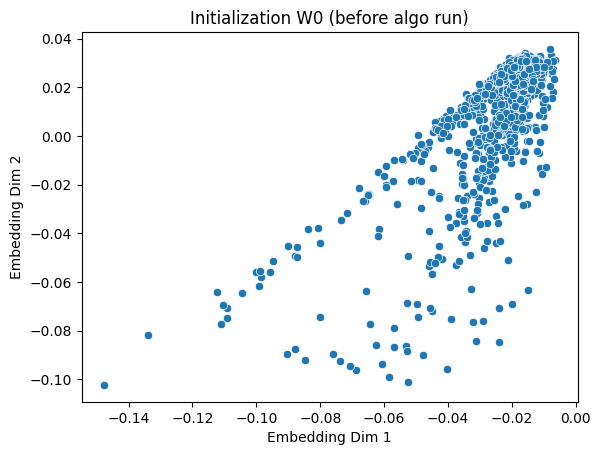

In [48]:
sns.scatterplot(x=W0[:,0], y=W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

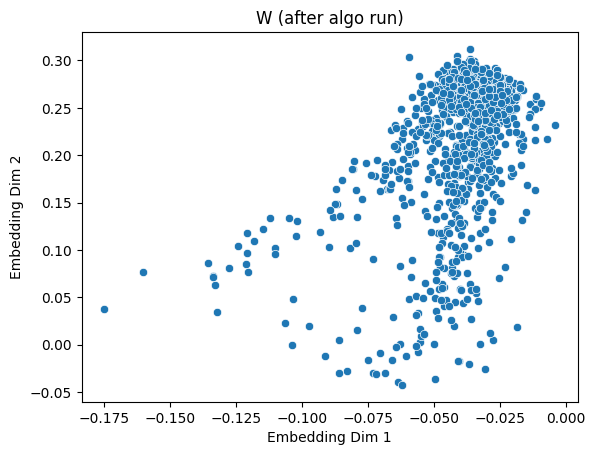

In [49]:
sns.scatterplot(x=W_3b[:,0], y=W_3b[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

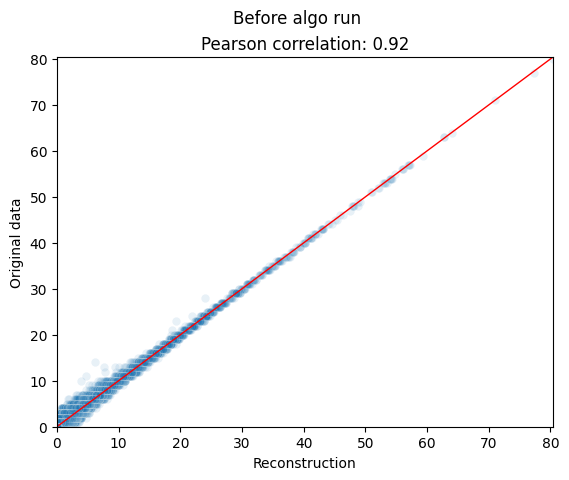

In [50]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

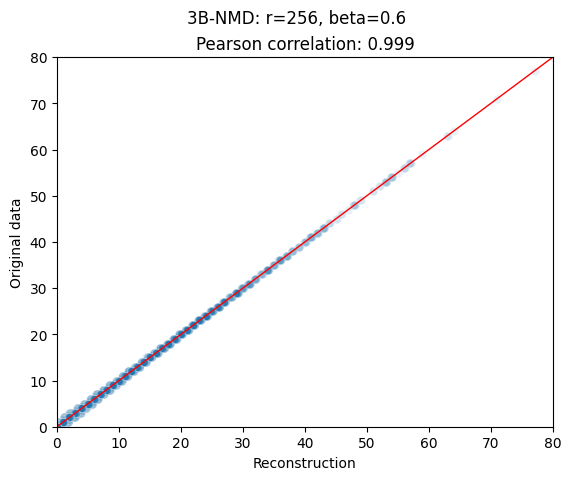

In [51]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b), X_nmd, "3B-NMD: r=256, beta=0.6", type="scatter", sample_fraction=None)

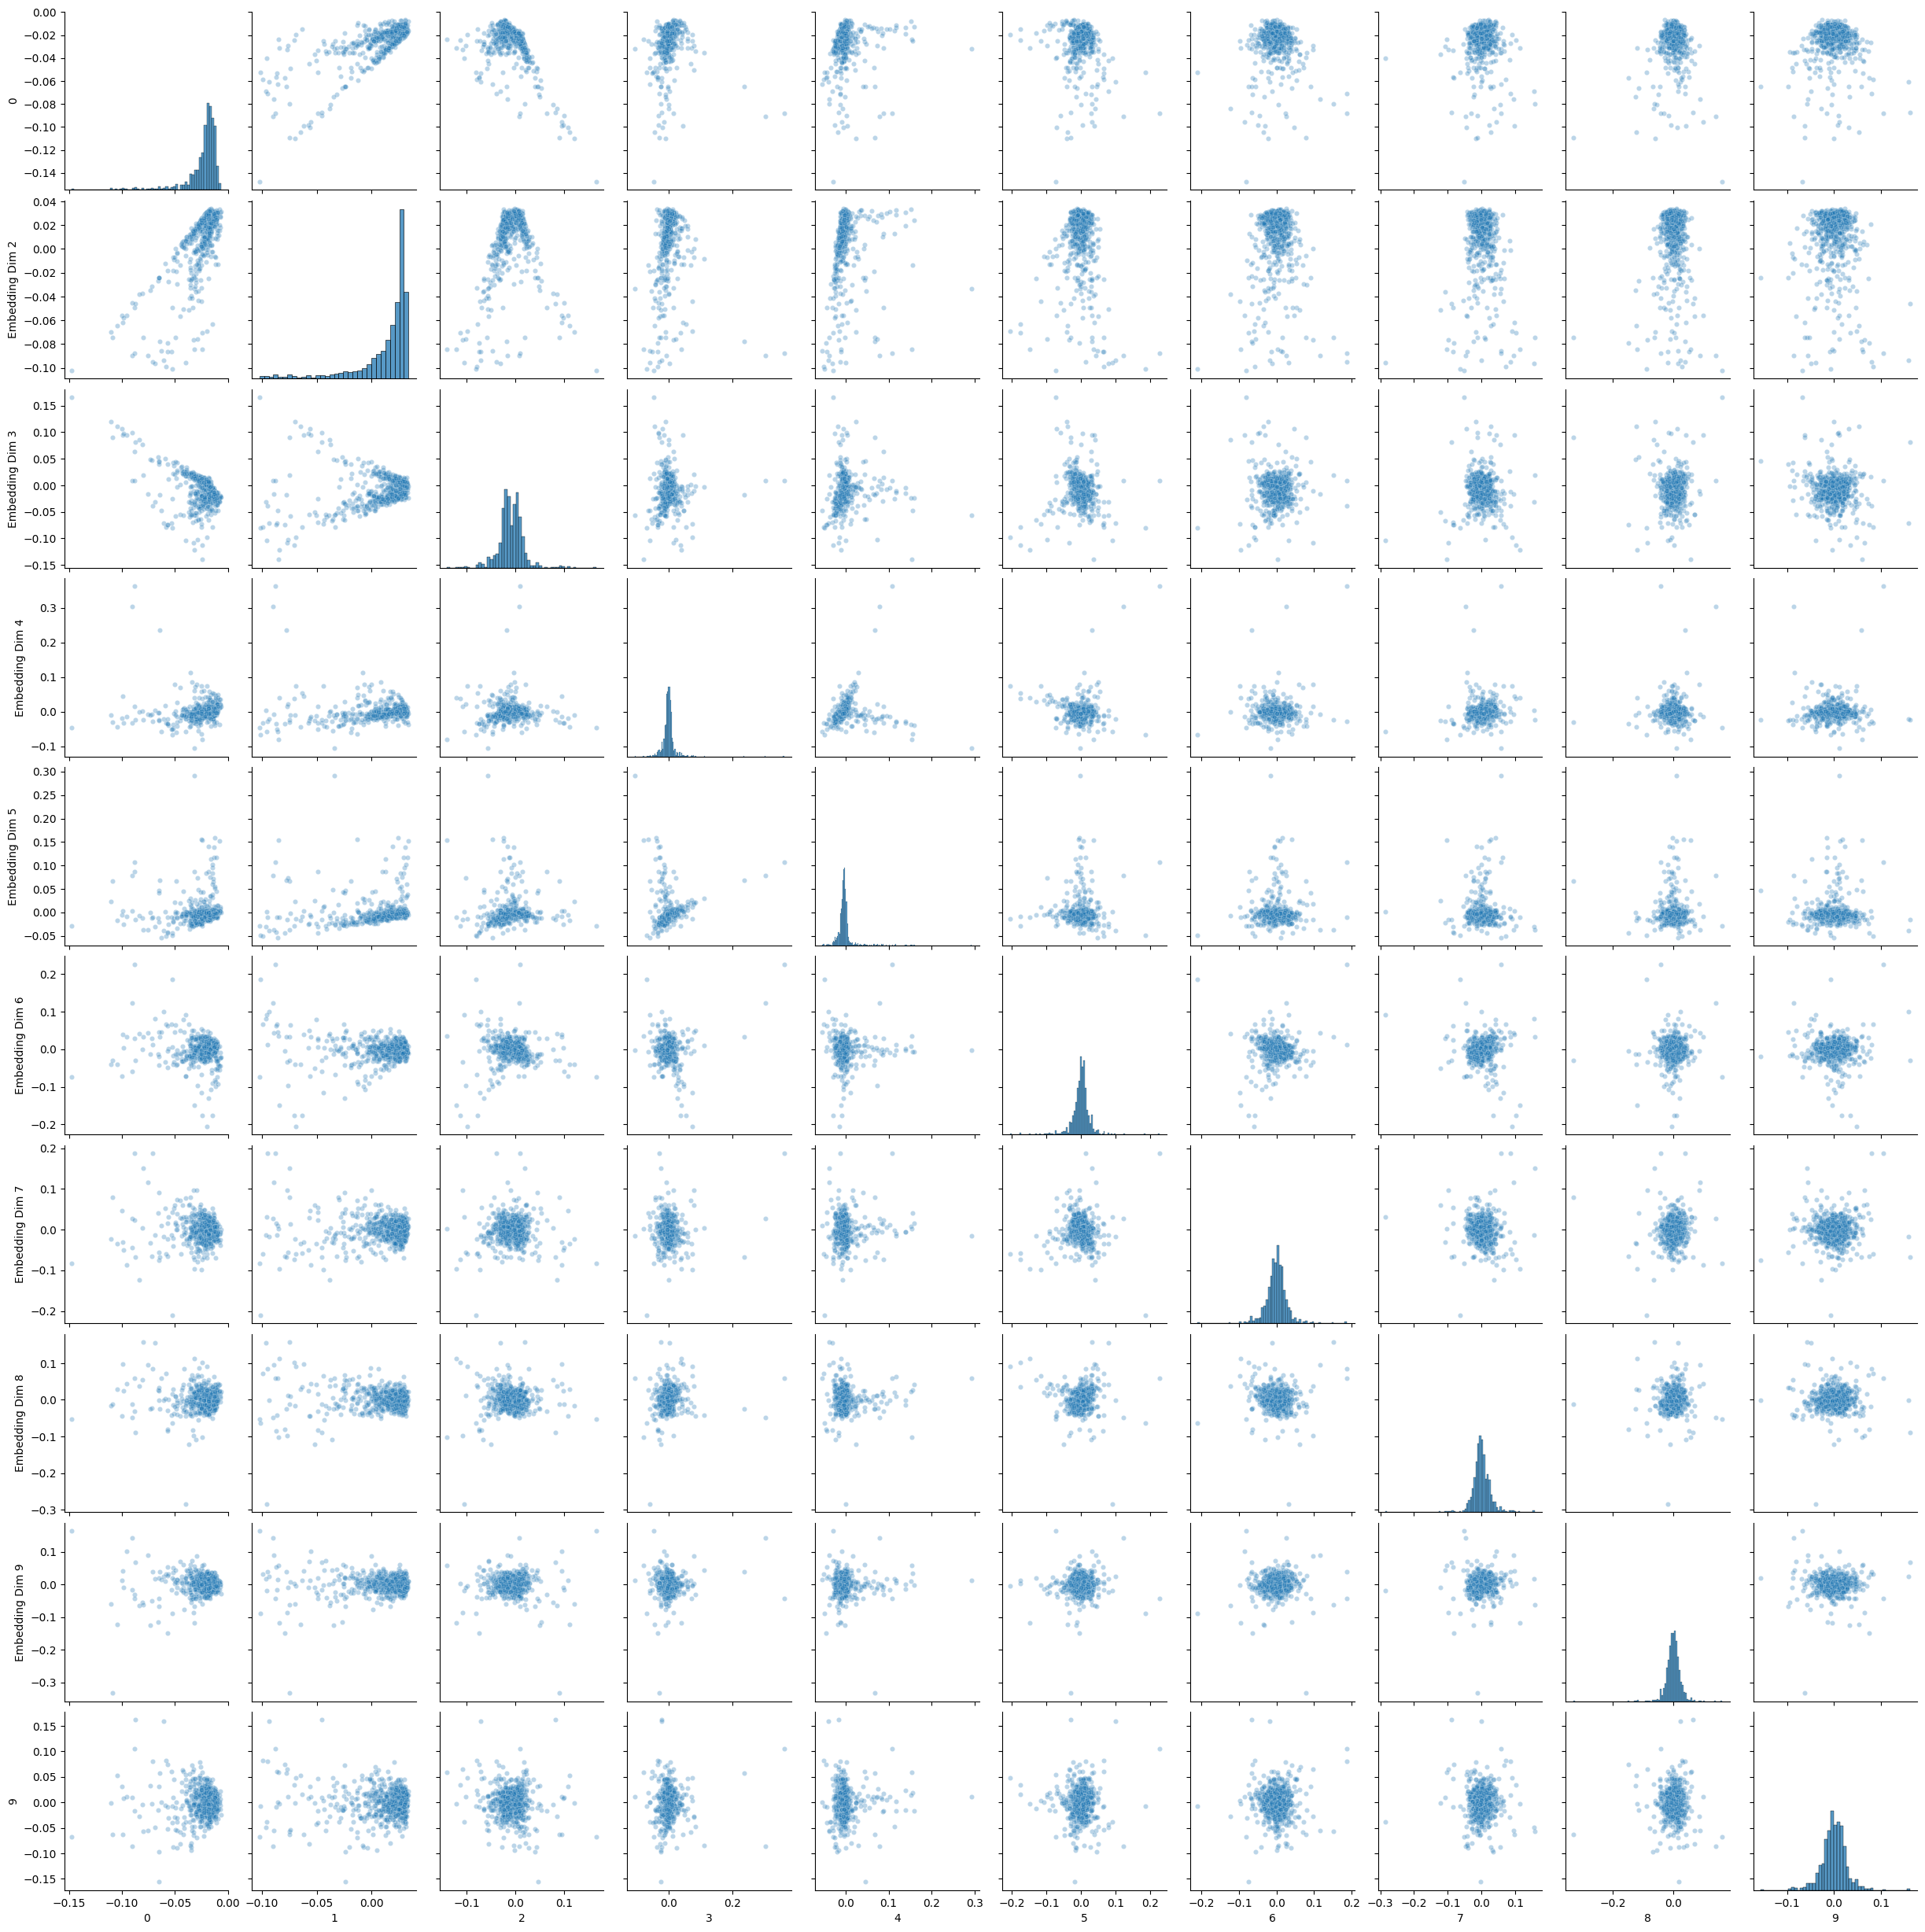

In [52]:
plot_embedding_grid(W0[:,0:10], title_prefix="Before nuclear init", sample_fraction=0.6)

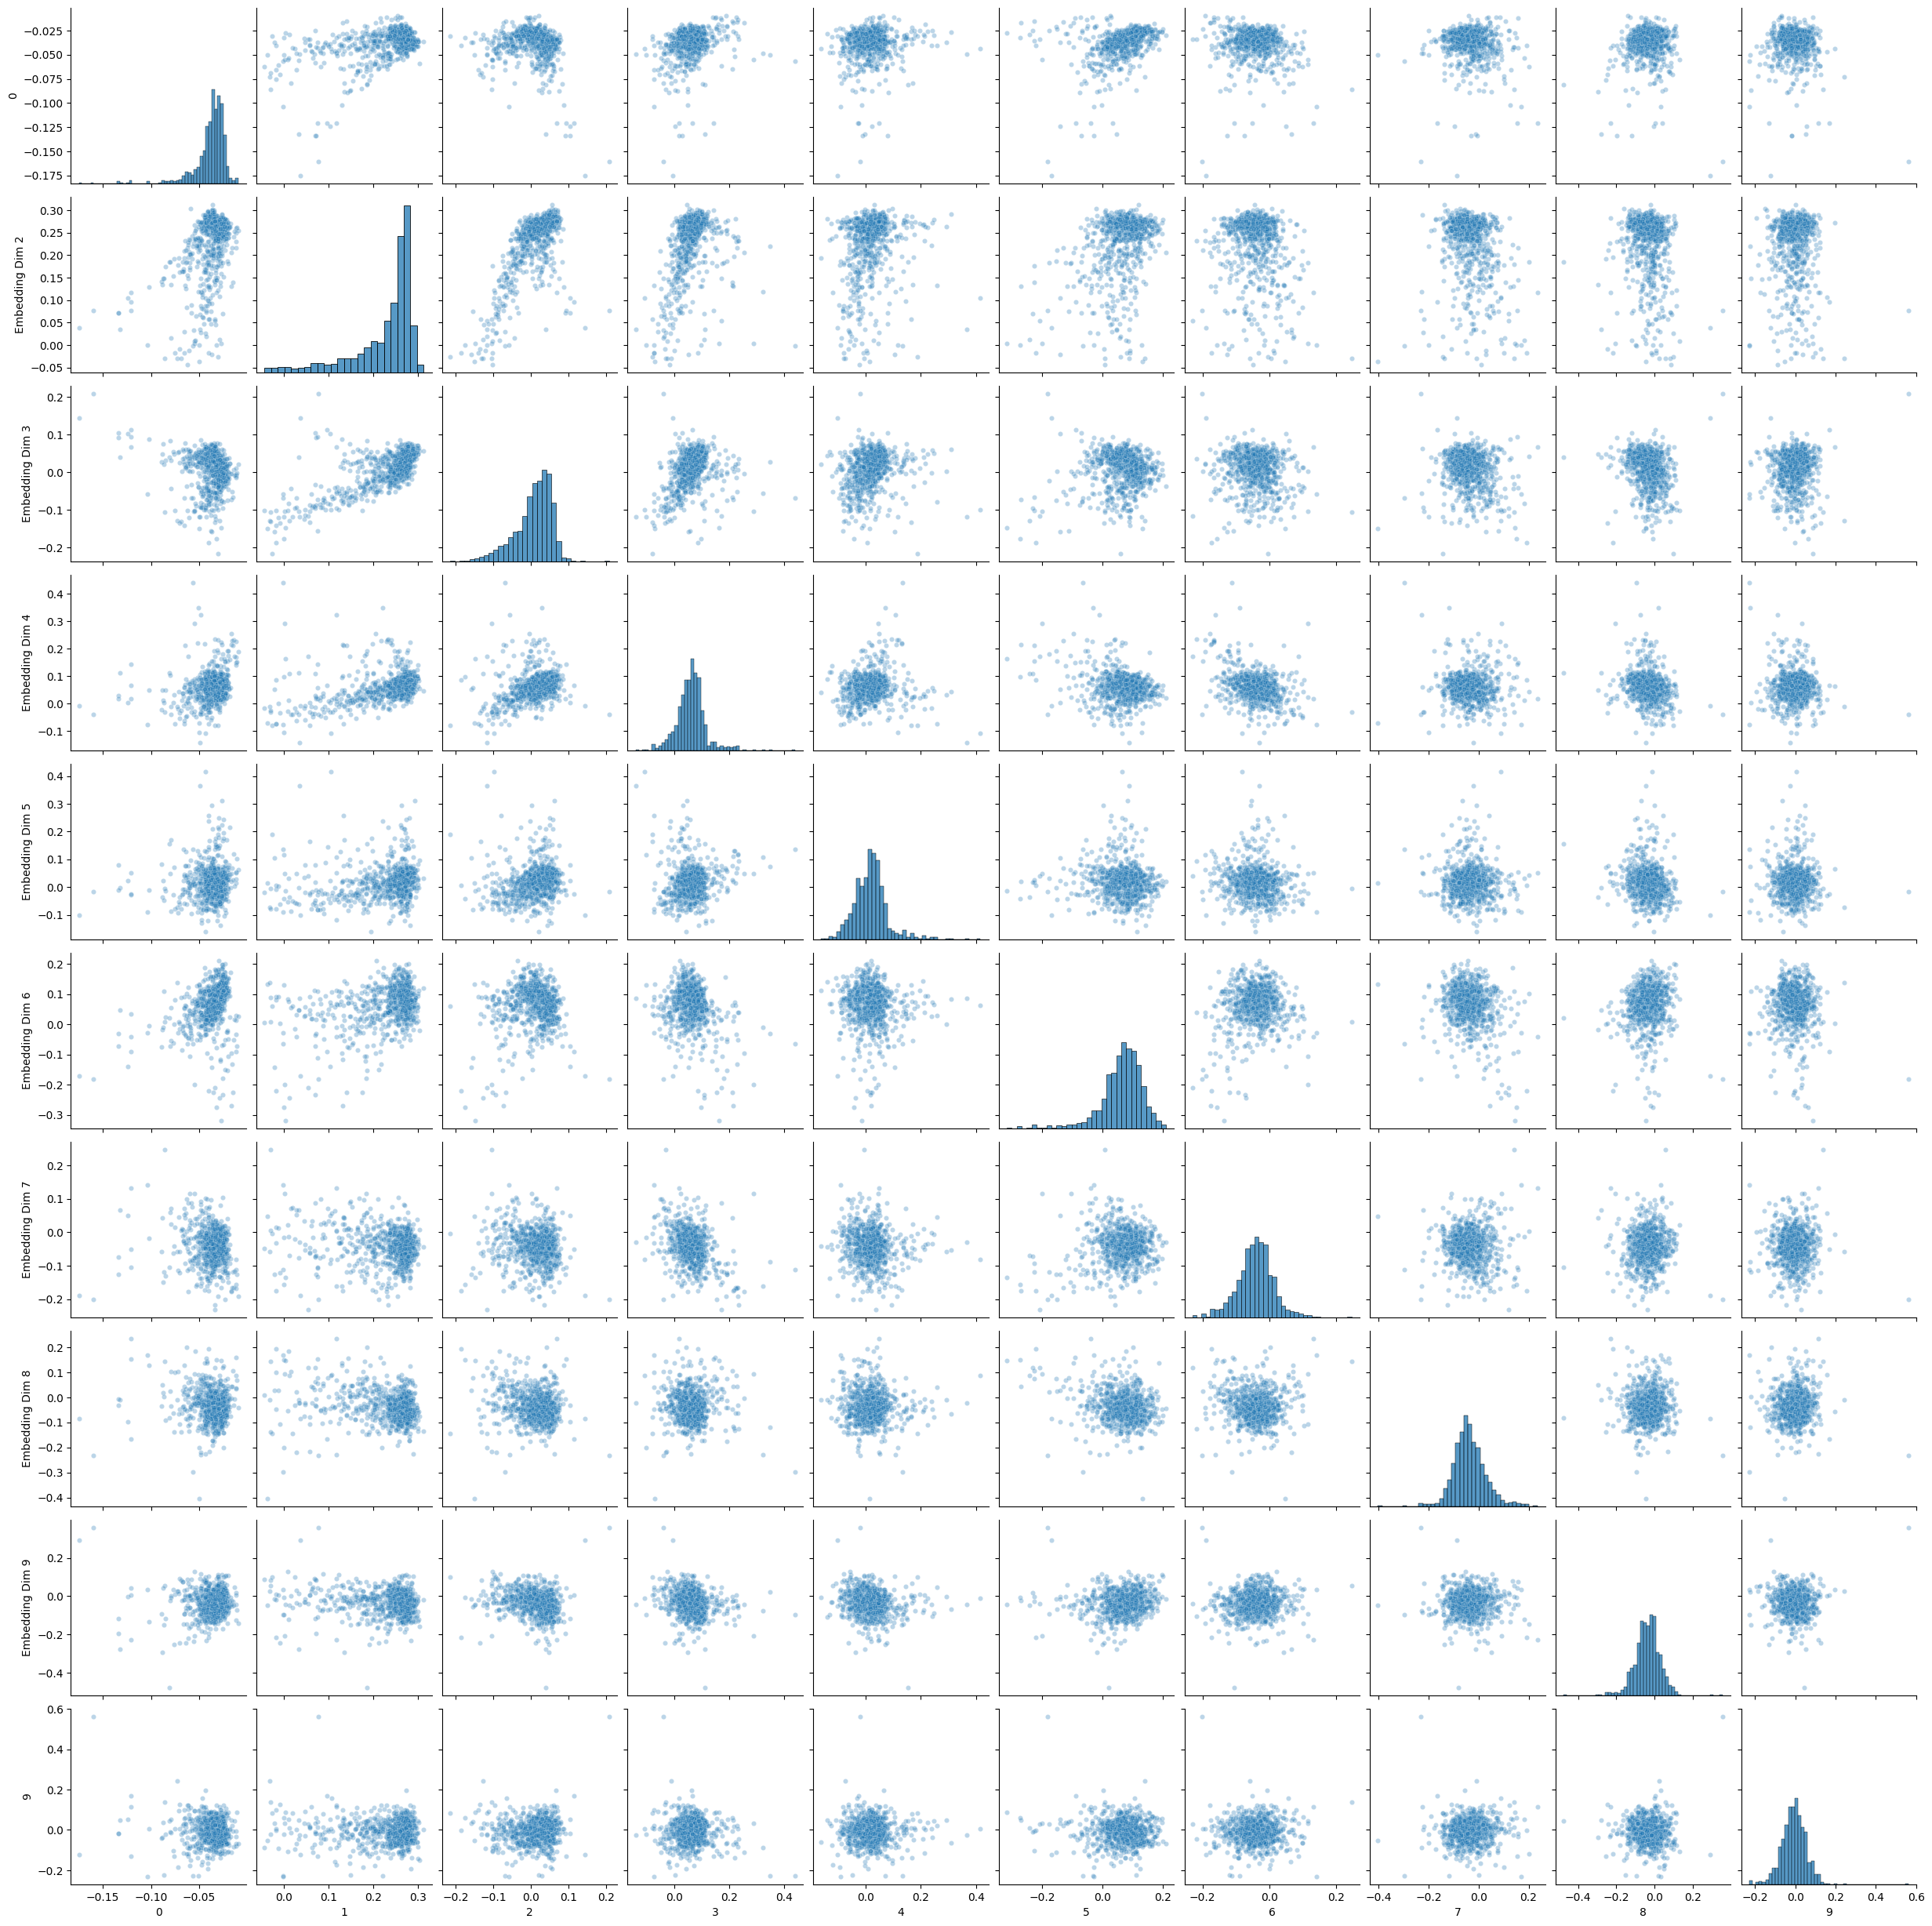

In [53]:
plot_embedding_grid(W_3b[:,0:10], title_prefix="After algo run", sample_fraction=0.6)